### Data and libraries import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import KFold
from itertools import product
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import os
import random

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, 
                            recall_score, precision_score, roc_auc_score, roc_curve, 
                            precision_recall_curve, average_precision_score, classification_report)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

from matplotlib.colors import TwoSlopeNorm
from sklearn.decomposition import PCA

In [2]:
tier_order = ["low", "medium", "high"]
price_tier_map = {"low": 0, "medium": 1, "high": 2}

df_iphone = pd.read_csv("data/iphone_kmc.csv")
df_iphone["price_tier"] = pd.Categorical(df_iphone["price_tier"], categories=tier_order, ordered=True)
df_iphone["price_tier_encoded"] = df_iphone["price_tier"].map(price_tier_map).astype(int)
summary_iphone = df_iphone.groupby(["price_tier_encoded"]).agg({
    "price.value": ['count', 'mean', 'min', "median", 'max']})
print("iPhone Summary")
print(summary_iphone, "\n")

df_soccer = pd.read_csv("data/soccer_kmc.csv")
df_soccer["price_tier"] = pd.Categorical(df_soccer["price_tier"], categories=tier_order, ordered=True)
df_soccer["price_tier_encoded"] = df_soccer["price_tier"].map(price_tier_map).astype(int)
df_soccer = df_soccer[df_soccer['year'].notna()]
summary_soccer = df_soccer.groupby(["price_tier_encoded"]).agg({
    "price.value": ['count', 'mean', 'min', "median", 'max']})
print("Soccer Summary")
print(summary_soccer, "\n")

print("iPhone price std dev:")
print(df_iphone["price.value"].std())

print("\n", "Soccer std dev:")
print(df_soccer["price.value"].std())

iPhone Summary
                   price.value                                      
                         count        mean     min   median      max
price_tier_encoded                                                  
0                          124  352.649919  215.00  349.915   439.99
1                          166  536.551687  446.99  537.975   650.00
2                           96  848.694583  650.00  776.995  1449.99 

Soccer Summary
                   price.value                                 
                         count       mean    min median     max
price_tier_encoded                                             
0                          234  29.398974   5.94  28.99   38.50
1                          296  49.936689  38.88  49.99   60.00
2                          214  83.014159  60.00  73.50  299.99 

iPhone price std dev:
213.02099455818362

 Soccer std dev:
28.336472098932514


### iPhone

#### Classification

In [3]:
X_iphone = df_iphone.drop(columns=["itemId", "title", "conditionId", "price.value", 
                                   "price_tier", "seller.username", "condition_desc", 
                                   "category_id", "price.currency", "cluster", 
                                   "price_tier_encoded", "marketingPrice.originalPrice.value",
                                   "discount_flag", "unlocked"])

X_iphone["marketingPrice.discountPercentage"] = X_iphone["marketingPrice.discountPercentage"].fillna(0).astype(int)
X_iphone["model_number"] = X_iphone["model_number"].astype(str)

bool_cols = X_iphone.select_dtypes(include=['bool']).columns.tolist()
numeric_cols = X_iphone.select_dtypes(include=['int', 'float']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in bool_cols]

sc = StandardScaler()
X_scaled_num_array = sc.fit_transform(X_iphone[numeric_cols])
X_scaled_num_iphone = pd.DataFrame(X_scaled_num_array, columns=numeric_cols, index=X_iphone.index)
X_bool_iphone  = X_iphone[bool_cols].astype(int)
X_comb = pd.concat([X_scaled_num_iphone, X_bool_iphone], axis=1)

categorical_cols = ['condition', 'itemLocation.country', 'category_name', 'specific_carrier', "model_number", "storage", "model_variant"]
X_encoded_iphone = pd.get_dummies(X_comb.join(X_iphone[categorical_cols]), columns=categorical_cols, drop_first=True)

y_iphone = df_iphone['price_tier_encoded']
                         
X_train_iphone, X_test_iphone, y_train_iphone, y_test_iphone = train_test_split(X_encoded_iphone, y_iphone,
                                                                 test_size=0.20, random_state=1216) 

#split training set into train / validation for model building
X_train_iphone, X_val_iphone, y_train_iphone, y_val_iphone = train_test_split(X_train_iphone, y_train_iphone,
                                                                test_size=0.20, random_state=1216)

print(X_train_iphone.shape, X_val_iphone.shape, X_test_iphone.shape)
print(y_train_iphone.shape, y_val_iphone.shape, y_test_iphone.shape)

#for MLR or others, full training set
X_train_full_iphone = np.concatenate((X_train_iphone, X_val_iphone), axis=0)
y_train_full_iphone = np.concatenate((y_train_iphone, y_val_iphone), axis=0)

(246, 42) (62, 42) (78, 42)
(246,) (62,) (78,)


In [4]:
X_iphone.dtypes

condition                             object
seller.feedbackPercentage            float64
seller.feedbackScore                   int64
topRatedBuyingExperience                bool
priorityListing                         bool
itemLocation.country                  object
marketingPrice.discountPercentage      int64
shipping_cost                        float64
days_listed                            int64
category_name                         object
seller_item_count                      int64
model_number                          object
additional_image_count                 int64
title_length                           int64
specific_carrier                      object
storage                               object
model_variant                         object
dtype: object

In [4]:
os.environ['PYTHONHASHSEED'] = '1216'
random.seed(1216)
np.random.seed(1216)
torch.manual_seed(1216)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

X_train_iphone = X_train_iphone.astype(np.float32)
X_val_iphone = X_val_iphone.astype(np.float32)
X_test_iphone = X_test_iphone.astype(np.float32)

X_train_tensor_iphone = torch.tensor(X_train_iphone.values, dtype=torch.float32)
X_val_tensor_iphone = torch.tensor(X_val_iphone.values, dtype=torch.float32)
X_test_tensor_iphone = torch.tensor(X_test_iphone.values, dtype=torch.float32)

y_train_tensor_iphone = torch.tensor(y_train_iphone.values, dtype=torch.long)
y_val_tensor_iphone = torch.tensor(y_val_iphone.values, dtype=torch.long)
y_test_tensor_iphone = torch.tensor(y_test_iphone.values, dtype=torch.long)

train_dataset_iphone = TensorDataset(X_train_tensor_iphone, y_train_tensor_iphone)
val_dataset_iphone = TensorDataset(X_val_tensor_iphone, y_val_tensor_iphone)
test_dataset_iphone = TensorDataset(X_test_tensor_iphone, y_test_tensor_iphone)

train_loader_iphone = DataLoader(train_dataset_iphone, batch_size=32, shuffle=True)
val_loader_iphone = DataLoader(val_dataset_iphone, batch_size=32, shuffle=False)
test_loader_iphone = DataLoader(test_dataset_iphone, batch_size=32, shuffle=False)

In [5]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, units, dropout, n_layers, num_classes):
        super(SimpleNN, self).__init__()
        layers = []
        # First layer
        layers.append(nn.Linear(input_dim, units))
        layers.append(nn.BatchNorm1d(units)) 
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        # Hidden layers
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(units, units))
            layers.append(nn.BatchNorm1d(units)) 
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        # Output layer: one output per class
        layers.append(nn.Linear(units, num_classes)) 
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)
    
def train_and_evaluate(units, dropout, lr, n_layers, epochs=10):
    model = SimpleNN(input_dim=X_train_tensor_iphone.shape[1], units=units, dropout=dropout, n_layers=n_layers, num_classes=3)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader_iphone:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        # Validation per epoch
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader_iphone:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
                val_correct += (preds.argmax(dim=1) == yb).sum().item()
                val_total += yb.size(0)
        val_loss /= val_total
        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    return val_loss, val_acc


In [7]:
# from itertools import product
# param_grid = {
#     'units': [32, 64],
#     'dropout': [0.3, 0.4, 0.5],
#     'learning_rate': [0.0005, 0.001, 0.005, 0.01],
#     'n_layers': [1, 2, 3]
# }
# results = []
# for units, dropout, lr, n_layers in product(param_grid['units'], param_grid['dropout'], param_grid['learning_rate'],
#                                  param_grid['n_layers']):
#     val_loss, val_acc = train_and_evaluate(units, dropout, lr, n_layers, 15)
#     print(f"units={units}, dropout={dropout}, lr={lr}, n_layers={n_layers}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
#     results.append({'units': units, 'dropout': dropout, 'lr': lr, 'n_layers': n_layers, 'val_loss': val_loss, 'val_acc': val_acc})

In [8]:
# best = min(results, key=lambda x: x['val_loss'])
# print(f"Best hyperparams: {best}")
# best_params = {k: best[k] for k in ['units', 'dropout', 'lr', 'n_layers']}

Best hyperparams: {'units': 32, 'dropout': 0.3, 'lr': 0.005, 'n_layers': 1, 'val_loss': 0.3963206458476282, 'val_acc': 0.8870967741935484}


In [ ]:
# X_combined_iphone = torch.cat([X_train_tensor_iphone, X_val_tensor_iphone], dim=0)
# y_combined_iphone = torch.cat([y_train_tensor_iphone, y_val_tensor_iphone], dim=0)
# combined_dataset_iphone = TensorDataset(X_combined_iphone, y_combined_iphone)
# combined_loader_iphone = DataLoader(combined_dataset_iphone, batch_size=32, shuffle=True)

# # Create new model using best hyperparameters
# final_model = SimpleNN(
#     input_dim=X_train_tensor_iphone.shape[1],
#     units=32,
#     dropout=0.3,
#     n_layers=1,
#     num_classes=3
# )
# optimizer = torch.optim.AdamW(final_model.parameters(), lr=0.005)
# criterion = torch.nn.CrossEntropyLoss()

# train_losses = []
# train_accuracies = []

# for epoch in range(50):
#     final_model.train()
#     running_loss = 0
#     correct = 0
#     total = 0
#     for xb, yb in combined_loader_iphone:
#         optimizer.zero_grad()
#         preds = final_model(xb)  
#         loss = criterion(preds, yb)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * xb.size(0)
#         predicted_classes = preds.argmax(dim=1)
#         correct += (predicted_classes == yb).sum().item()
#         total += yb.size(0)
#     epoch_loss = running_loss / total
#     epoch_acc = correct / total
#     train_losses.append(epoch_loss)
#     train_accuracies.append(epoch_acc)
#     print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

#torch.save(final_model.state_dict(), "models/final_model_iphone.pth")


In [10]:
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML
# import numpy as np

# train_losses = np.array(train_losses)
# train_accuracies = np.array(train_accuracies)

# epochs = np.arange(1, len(train_losses) + 1)

# fig, ax1 = plt.subplots(figsize=(8,5))

# ax2 = ax1.twinx()

# line_loss, = ax1.plot([], [], 'r-', label='Loss')
# line_acc, = ax2.plot([], [], 'b-', label='Accuracy')

# ax1.set_xlim(1, len(epochs))
# ax1.set_ylim(train_losses.min()*0.9, train_losses.max()*1.1)
# ax2.set_ylim(train_accuracies.min()*0.9, train_accuracies.max()*1.1)

# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Loss', color='r')
# ax2.set_ylabel('Accuracy', color='b')
# ax1.set_title('Training Loss and Accuracy Over Epochs')

# ax1.legend(loc='upper left')
# ax2.legend(loc='upper right')

# def update(frame):
#     x = epochs[:frame+1]
#     y_loss = train_losses[:frame+1]
#     y_acc = train_accuracies[:frame+1]
#     line_loss.set_data(x, y_loss)
#     line_acc.set_data(x, y_acc)
#     return line_loss, line_acc

# ani = FuncAnimation(fig, update, frames=len(epochs), interval=500, blit=True, repeat=False)
# ani.save("images/5/training_progress.gif", writer='pillow', fps=2)

# plt.close(fig)  # Prevent static plot output in notebook

# HTML(ani.to_jshtml())


              precision    recall  f1-score   support

         low       0.91      0.91      0.91        22
      medium       0.82      0.82      0.82        17
        high       0.87      0.87      0.87        39

    accuracy                           0.87        78
   macro avg       0.87      0.87      0.87        78
weighted avg       0.87      0.87      0.87        78



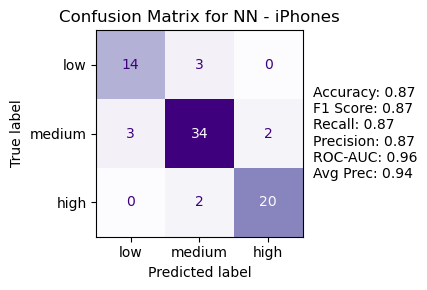

Accuracy: 0.8718
F1 Score: 0.8718
Recall Score: 0.8718


In [6]:
final_model = SimpleNN(
    input_dim=X_train_tensor_iphone.shape[1],
    units=32,
    dropout=0.3,
    n_layers=1,
    num_classes=3
)
final_model.load_state_dict(torch.load("models/final_model_iphone.pth"))

final_model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for xb, yb in test_loader_iphone:
        preds = final_model(xb)
        predicted_classes = preds.argmax(dim=1)
        logits = final_model(xb)               # raw outputs (logits)
        probs = torch.softmax(logits, dim=1)  # convert logits to probabilities
        all_probs.append(probs.cpu().numpy())
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

all_probs = np.vstack(all_probs)

idx_to_label = {0: "low", 1: "medium", 2: "high"}
tier_order = ["low", "medium", "high"]

# Map numeric labels back to strings
all_labels_str = [idx_to_label[idx] for idx in all_labels]
all_preds_str = [idx_to_label[idx] for idx in all_preds]
all_labels_bin = label_binarize(all_labels, classes=[0,1,2])
print(classification_report(all_labels_str, all_preds_str, target_names=tier_order))

accuracy = accuracy_score(all_labels_str, all_preds_str)
f1 = f1_score(all_labels_str, all_preds_str, average="weighted")
recall = recall_score(all_labels_str, all_preds_str, average="weighted")
prec = precision_score(all_labels_str, all_preds_str, average="weighted")
roc_auc = roc_auc_score(all_labels_bin, all_probs)
avg_prec = average_precision_score(all_labels_bin, all_probs)

cm_iphone = confusion_matrix(all_labels_str, all_preds_str, labels=tier_order)
fig, ax = plt.subplots(figsize=(5,3))
disp_iphone = ConfusionMatrixDisplay(confusion_matrix=cm_iphone, display_labels=tier_order)
disp_iphone.plot(ax=ax, cmap="Purples", colorbar=False)
disp_iphone.ax_.set_title('Confusion Matrix for NN - iPhones')

textstr = f'Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nRecall: {recall:.2f}\nPrecision: {prec:.2f}\nROC-AUC: {roc_auc:.2f}\nAvg Prec: {avg_prec:.2f}'
ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center')
plt.tight_layout()
plt.savefig("images/5/cm_nn_iphone.png", dpi=300, bbox_inches='tight')#, facecolor="#E7E7E7")
plt.show()

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall Score: {recall:.4f}')



In [7]:
labels_df = pd.DataFrame({
    "true_label": all_labels_str,
    "predicted_label": all_preds_str
}, index=y_test_iphone.index)

# Merge labels with original iPhone dataframe on index
merged = df_iphone.loc[y_test_iphone.index].copy()
merged = merged.join(labels_df)

# Identify underpriced and overpriced cases based on true vs predicted
underpriced = merged[(merged["true_label"] == "low") & (merged["predicted_label"] == "high")]
overpriced = merged[(merged["true_label"] == "high") & (merged["predicted_label"] == "low")]

print("Underpriced Candidates:")
display(underpriced[["title", "price.value", "seller.feedbackScore", "days_listed", "title_length", "true_label", "predicted_label"]])

print("Overpriced Candidates:")
display(overpriced[["title", "price.value", "seller.feedbackScore", "days_listed", "title_length", "true_label", "predicted_label"]])

Underpriced Candidates:


,title,price.value,seller.feedbackScore,days_listed,title_length,true_label,predicted_label


Overpriced Candidates:


,title,price.value,seller.feedbackScore,days_listed,title_length,true_label,predicted_label


In [8]:
for name, param in final_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: shape {param.shape}")
        print(param.data)

net.0.weight: shape torch.Size([32, 42])
tensor([[ 3.7532e-02, -4.7558e-02,  1.6302e-01,  ...,  1.5895e-01,
         -4.5745e-01,  1.9295e-01],
        [-7.7137e-03,  9.3463e-02,  1.9352e-02,  ..., -2.3568e-01,
          2.1308e-01,  1.3299e-01],
        [-9.7914e-02,  5.6846e-02, -3.3914e-02,  ...,  3.5116e-01,
         -4.7371e-01,  3.8527e-01],
        ...,
        [ 1.6822e-02,  1.1287e-01,  1.4975e-02,  ..., -2.3990e-01,
          1.9548e-01,  1.6425e-01],
        [-2.8147e-03,  5.0253e-02,  3.2259e-02,  ..., -2.5435e-01,
          4.1138e-02,  1.2131e-01],
        [-8.8828e-02,  9.4076e-03, -3.0626e-04,  ...,  2.9607e-01,
         -2.0641e-01,  1.0014e-01]])
net.0.bias: shape torch.Size([32])
tensor([ 0.0597, -0.1808,  0.0673,  0.0689, -0.0526,  0.0423,  0.0821, -0.0552,
        -0.1163,  0.0559,  0.1538, -0.0656,  0.1005, -0.1164,  0.0992,  0.0233,
        -0.0630, -0.0878, -0.0095, -0.1222, -0.0083,  0.0415,  0.0974, -0.1665,
        -0.0129, -0.1068,  0.0629,  0.1503, -0.1506,

In [9]:
print(final_model)

SimpleNN(
  (net): Sequential(
    (0): Linear(in_features=42, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=32, out_features=3, bias=True)
  )
)


#### Regression

In [15]:
y_iphone = df_iphone['price.value']
                         
X_train_iphone, X_test_iphone, y_train_iphone, y_test_iphone = train_test_split(X_encoded_iphone, y_iphone,
                                                                 test_size=0.20, random_state=1216) 

X_train_iphone, X_val_iphone, y_train_iphone, y_val_iphone = train_test_split(X_train_iphone, y_train_iphone,
                                                                test_size=0.20, random_state=1216)

y_train_tensor_iphone = torch.tensor(y_train_iphone.values, dtype=torch.float32).view(-1, 1)
y_val_tensor_iphone = torch.tensor(y_val_iphone.values, dtype=torch.float32).view(-1, 1)
y_test_tensor_iphone = torch.tensor(y_test_iphone.values, dtype=torch.float32).view(-1, 1)

train_dataset_iphone = TensorDataset(X_train_tensor_iphone, y_train_tensor_iphone)
val_dataset_iphone = TensorDataset(X_val_tensor_iphone, y_val_tensor_iphone)
test_dataset_iphone = TensorDataset(X_test_tensor_iphone, y_test_tensor_iphone)

train_loader_iphone = DataLoader(train_dataset_iphone, batch_size=32, shuffle=True)
val_loader_iphone = DataLoader(val_dataset_iphone, batch_size=32, shuffle=False)
test_loader_iphone = DataLoader(test_dataset_iphone, batch_size=32, shuffle=False)

In [16]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, units, dropout, n_layers):
        super(SimpleNN, self).__init__()
        layers = []
        # First layer
        layers.append(nn.Linear(input_dim, units))
        layers.append(nn.BatchNorm1d(units)) 
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        # Hidden layers
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(units, units))
            layers.append(nn.BatchNorm1d(units)) 
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(units, 1))  
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    
def train_and_evaluate(units, dropout, lr, n_layers, epochs=10):
    model = SimpleNN(input_dim=X_train_tensor_iphone.shape[1], units=units, dropout=dropout, n_layers=n_layers)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader_iphone:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        # Validation per epoch
        model.eval()
        val_loss = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader_iphone:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
                val_total += yb.size(0)
        val_loss /= val_total
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}")
    return val_loss

In [17]:
# from itertools import product
# param_grid = {
#     'units': [32, 64],
#     'dropout': [0.3, 0.4, 0.5],
#     'learning_rate': [0.001, 0.005, 0.01],
#     'n_layers': [1, 2, 3]
# }
# results = []
# for units, dropout, lr, n_layers in product(param_grid['units'], param_grid['dropout'], param_grid['learning_rate'],
#                                  param_grid['n_layers']):
#     val_loss = train_and_evaluate(units, dropout, lr, n_layers, 15)
#     print(f"units={units}, dropout={dropout}, lr={lr}, n_layers={n_layers}, val_loss={val_loss:.4f}")
#     results.append({'units': units, 'dropout': dropout, 'lr': lr, 'n_layers': n_layers, 'val_loss': val_loss})

In [18]:
# best = min(results, key=lambda x: x['val_loss'])
# print(f"Best hyperparams: {best}")
# best_params = {k: best[k] for k in ['units', 'dropout', 'lr', 'n_layers']}

Best hyperparams: {'units': 64, 'dropout': 0.3, 'lr': 0.01, 'n_layers': 3, 'val_loss': 149725.18800403227}


In [ ]:
# X_combined_iphone = torch.cat([X_train_tensor_iphone, X_val_tensor_iphone], dim=0)
# y_combined_iphone = torch.cat([y_train_tensor_iphone, y_val_tensor_iphone], dim=0)
# combined_dataset_iphone = TensorDataset(X_combined_iphone, y_combined_iphone)
# combined_loader_iphone = DataLoader(combined_dataset_iphone, batch_size=32, shuffle=True)

# # Create new model using best hyperparameters
# final_model = SimpleNN(
#     input_dim=X_train_tensor_iphone.shape[1],
#     units=64,
#     dropout=0.3,
#     n_layers=3,
# )
# optimizer = torch.optim.AdamW(final_model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

# train_losses = []

# for epoch in range(50):
#     final_model.train()
#     running_loss = 0
#     total = 0
#     for xb, yb in combined_loader_iphone:
#         optimizer.zero_grad()
#         preds = final_model(xb)  # shape: [batch_size, num_classes]
#         loss = criterion(preds, yb)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * xb.size(0)
#         total += yb.size(0)
#     epoch_loss = running_loss / total
#     train_losses.append(epoch_loss)
#     print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# torch.save(final_model.state_dict(), "models/final_model_iphone_reg.pth")


In [ ]:
final_model = SimpleNN(
    input_dim=X_train_tensor_iphone.shape[1],
    units=64,
    dropout=0.3,
    n_layers=3,
)
final_model.load_state_dict(torch.load("models/final_model_iphone_reg.pth"))
criterion = torch.nn.MSELoss()

final_model.eval()
with torch.no_grad():
    preds = final_model(X_test_tensor_iphone)
    mse = criterion(preds, y_test_tensor_iphone).item()
    rmse = mse ** 0.5
    print(f"Test MSE: {mse:.2f}, RMSE: {rmse:.2f}")


Test MSE: 8926.94, RMSE: 94.48


In [21]:
print(final_model)

SimpleNN(
  (net): Sequential(
    (0): Linear(in_features=42, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [ ]:
final_model = SimpleNN(
    input_dim=X_train_tensor_iphone.shape[1],
    units=64,
    dropout=0.3,
    n_layers=3,
)
final_model.load_state_dict(torch.load("models/final_model_iphone_reg.pth"))

final_model.eval()
with torch.no_grad():
    preds = final_model(X_test_tensor_iphone).cpu().numpy().flatten()
    targets = y_test_iphone.values.flatten()

errors = preds - targets   # positive = underpriced, negative = overpriced
abs_errors = np.abs(errors)

top_n = 10
biggest_misses_pos = np.argsort(abs_errors)[-top_n:][::-1]  # positions in test set
orig_idx = X_test_iphone.index[biggest_misses_pos]           # original df_iphone index


misses_df = df_iphone.loc[orig_idx, ["title", "model_number", "storage", "model_variant", "condition"]].copy()
misses_df["Predicted"] = preds[biggest_misses_pos]
misses_df["Actual"] = targets[biggest_misses_pos]
misses_df["Error"] = errors[biggest_misses_pos]
misses_df["Price_Tag"] = np.where(
    misses_df["Error"] > 0,
    "Potentially Underpriced",
    "Potentially Overpriced"
)

print(f"Top {top_n} biggest misses:")
print(misses_df.sort_values(by="Error", key=np.abs, ascending=False))


Top 10 biggest misses:
                                                 title  model_number storage  \
18   Apple iPhone 16 Pro - 256 GB - Space Black - AT&T          16.0   256GB   
19              Apple iPhone 16 Pro Max 256GB Unlocked          16.0   256GB   
149  Apple iPhone 16 6.1" REAL Dual SIM Hong Kong A...          16.0   128GB   
201  Apple iPhone 16 Pro Max - Unlocked - Natural T...          16.0   512GB   
1    Apple iPhone 16 Plus A3082 - AT&T Only - 128GB...          16.0   128GB   
57   Apple iPhone 16 Pro A3083 MYMG3LL/A 256GB  AT&...          16.0   256GB   
190  NEW*  Apple iPhone 16 | 256GB Ultramarine Blu...          16.0   256GB   
229              Apple iPhone 14 - 128 GB 5G Black ATT          14.0   128GB   
285  Apple iPhone 16 - Unlocked - Teal - 128GB - Ex...          16.0   128GB   
148  NEW! Apple iPhone 14 6.1"  100% 🔋 Battery  Fac...          14.0   512GB   

    model_variant                 condition    Predicted   Actual       Error  \
18            P

In [23]:
misses_df.sort_values(by="Error", key=np.abs, ascending=False)

,title,model_number,storage,model_variant,condition,Predicted,Actual,Error,Price_Tag
18,Apple iPhone 16 Pro - 256 GB - Space Black - AT&T,16.0,256GB,Pro,Used,913.040833,500.00,413.040833,Potentially Underpriced
19,Apple iPhone 16 Pro Max 256GB Unlocked,16.0,256GB,Pro Max,New,1108.308350,750.00,358.308350,Potentially Underpriced
149,"Apple iPhone 16 6.1"" REAL Dual SIM Hong Kong A...",16.0,128GB,none,New,883.678284,1098.00,-214.321716,Potentially Overpriced
201,Apple iPhone 16 Pro Max - Unlocked - Natural T...,16.0,512GB,Pro Max,New,1201.513184,1379.00,-177.486816,Potentially Overpriced
1,Apple iPhone 16 Plus A3082 - AT&T Only - 128GB...,16.0,128GB,Plus,Used,731.251465,567.99,163.261465,Potentially Underpriced
57,Apple iPhone 16 Pro A3083 MYMG3LL/A 256GB AT&...,16.0,256GB,Pro,For parts or not working,642.890137,800.00,-157.109863,Potentially Overpriced
190,NEW*  Apple iPhone 16 | 256GB Ultramarine Blu...,16.0,256GB,none,New,704.295471,849.99,-145.694529,Potentially Overpriced
229,Apple iPhone 14 - 128 GB 5G Black ATT,14.0,128GB,none,Used,358.860779,215.00,143.860779,Potentially Underpriced
285,Apple iPhone 16 - Unlocked - Teal - 128GB - Ex...,16.0,128GB,none,Used,623.701111,765.00,-141.298889,Potentially Overpriced
148,"NEW! Apple iPhone 14 6.1"" 100% 🔋 Battery Fac...",14.0,512GB,none,Open box,383.509247,519.00,-135.490753,Potentially Overpriced


#### Log price regression

In [24]:
y_iphone = df_iphone['price.value']
                         
X_train_iphone, X_test_iphone, y_train_iphone, y_test_iphone = train_test_split(X_encoded_iphone, y_iphone,
                                                                 test_size=0.20, random_state=1216) 

X_train_iphone, X_val_iphone, y_train_iphone, y_val_iphone = train_test_split(X_train_iphone, y_train_iphone,
                                                                test_size=0.20, random_state=1216)

y_train_log = np.log(y_train_iphone.values)
y_val_log = np.log(y_val_iphone.values)
y_test_log = np.log(y_test_iphone.values)

y_train_tensor_iphone_log = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
y_val_tensor_iphone_log = torch.tensor(y_val_log, dtype=torch.float32).view(-1, 1)
y_test_tensor_iphone_log = torch.tensor(y_test_log, dtype=torch.float32).view(-1, 1)

train_dataset_iphone_log = TensorDataset(X_train_tensor_iphone, y_train_tensor_iphone_log)
val_dataset_iphone_log = TensorDataset(X_val_tensor_iphone, y_val_tensor_iphone_log)
test_dataset_iphone_log = TensorDataset(X_test_tensor_iphone, y_test_tensor_iphone_log)

train_loader_iphone_log = DataLoader(train_dataset_iphone_log, batch_size=32, shuffle=True)
val_loader_iphone_log = DataLoader(val_dataset_iphone_log, batch_size=32, shuffle=False)
test_loader_iphone_log = DataLoader(test_dataset_iphone_log, batch_size=32, shuffle=False)

In [25]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_and_evaluate(units, dropout, lr, n_layers, epochs=30, patience=5):
    model = SimpleNN(input_dim=X_train_tensor_iphone.shape[1], units=units, dropout=dropout, n_layers=n_layers)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader_iphone_log:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader_iphone_log:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
                val_total += yb.size(0)
        val_loss /= val_total
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping!")
                break
    return best_val_loss

In [26]:
from itertools import product
param_grid = {
    'units': [32, 64],
    'dropout': [0.3, 0.4, 0.5],
    'learning_rate': [0.0005, 0.001, 0.005, 0.01],
    'n_layers': [1, 2, 3]
}
results = []
for units, dropout, lr, n_layers in product(param_grid['units'], param_grid['dropout'], param_grid['learning_rate'],
                                 param_grid['n_layers']):
    val_loss = train_and_evaluate(units, dropout, lr, n_layers, 10)
    print(f"units={units}, dropout={dropout}, lr={lr}, n_layers={n_layers}, val_loss={val_loss:.4f}")
    results.append({'units': units, 'dropout': dropout, 'lr': lr, 'n_layers': n_layers, 'val_loss': val_loss})

Epoch 1, Val Loss: 39.3861
Epoch 2, Val Loss: 39.2588
Epoch 3, Val Loss: 38.7927
Epoch 4, Val Loss: 38.0460
Epoch 5, Val Loss: 37.2108
Epoch 6, Val Loss: 36.3806
Epoch 7, Val Loss: 35.6058
Epoch 8, Val Loss: 34.7062
Epoch 9, Val Loss: 33.9468
Epoch 10, Val Loss: 33.2737
units=32, dropout=0.3, lr=0.0005, n_layers=1, val_loss=33.2737
Epoch 1, Val Loss: 38.5952
Epoch 2, Val Loss: 37.6184
Epoch 3, Val Loss: 36.1198
Epoch 4, Val Loss: 34.8539
Epoch 5, Val Loss: 34.0069
Epoch 6, Val Loss: 32.9855
Epoch 7, Val Loss: 32.1992
Epoch 8, Val Loss: 31.4933
Epoch 9, Val Loss: 30.7558
Epoch 10, Val Loss: 30.1369
units=32, dropout=0.3, lr=0.0005, n_layers=2, val_loss=30.1369
Epoch 1, Val Loss: 37.5502
Epoch 2, Val Loss: 36.2027
Epoch 3, Val Loss: 35.2254
Epoch 4, Val Loss: 34.3117
Epoch 5, Val Loss: 33.9696
Epoch 6, Val Loss: 33.4708
Epoch 7, Val Loss: 32.9167
Epoch 8, Val Loss: 32.3284
Epoch 9, Val Loss: 31.7154
Epoch 10, Val Loss: 30.8827
units=32, dropout=0.3, lr=0.0005, n_layers=3, val_loss=30.882

In [27]:
best = min(results, key=lambda x: x['val_loss'])
print(f"Best hyperparams: {best}")
best_params = {k: best[k] for k in ['units', 'dropout', 'lr', 'n_layers']}

Best hyperparams: {'units': 64, 'dropout': 0.4, 'lr': 0.01, 'n_layers': 1, 'val_loss': 0.513751805790009}


In [28]:
X_combined_iphone = torch.cat([X_train_tensor_iphone, X_val_tensor_iphone], dim=0)
y_combined_iphone_log = torch.cat([y_train_tensor_iphone_log, y_val_tensor_iphone_log], dim=0)
combined_dataset_iphone_log = TensorDataset(X_combined_iphone, y_combined_iphone_log)
combined_loader_iphone_log = DataLoader(combined_dataset_iphone_log, batch_size=32, shuffle=True)

# Create new model using best hyperparameters
final_model = SimpleNN(
    input_dim=X_train_tensor_iphone.shape[1],
    units=best_params['units'],
    dropout=best_params['dropout'],
    n_layers=best_params['n_layers'],
)
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_params['lr'])
criterion = torch.nn.MSELoss()

train_losses = []

for epoch in range(50):
    final_model.train()
    running_loss = 0
    total = 0
    for xb, yb in combined_loader_iphone_log:
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        total += yb.size(0)
    epoch_loss = running_loss / total
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 29.5077
Epoch 2, Loss: 8.1022
Epoch 3, Loss: 2.2412
Epoch 4, Loss: 2.5810
Epoch 5, Loss: 1.4321
Epoch 6, Loss: 1.6068
Epoch 7, Loss: 1.4194
Epoch 8, Loss: 1.6474
Epoch 9, Loss: 1.8965
Epoch 10, Loss: 1.7259
Epoch 11, Loss: 1.3779
Epoch 12, Loss: 1.4193
Epoch 13, Loss: 1.2917
Epoch 14, Loss: 1.1263
Epoch 15, Loss: 1.1143
Epoch 16, Loss: 1.2479
Epoch 17, Loss: 1.1078
Epoch 18, Loss: 1.0419
Epoch 19, Loss: 1.1788
Epoch 20, Loss: 1.0533
Epoch 21, Loss: 1.0940
Epoch 22, Loss: 0.9429
Epoch 23, Loss: 0.9113
Epoch 24, Loss: 0.9887
Epoch 25, Loss: 0.7187
Epoch 26, Loss: 0.8476
Epoch 27, Loss: 0.8901
Epoch 28, Loss: 0.8954
Epoch 29, Loss: 0.9306
Epoch 30, Loss: 0.9085
Epoch 31, Loss: 0.9178
Epoch 32, Loss: 0.7245
Epoch 33, Loss: 0.7827
Epoch 34, Loss: 0.8243
Epoch 35, Loss: 0.7981
Epoch 36, Loss: 0.7834
Epoch 37, Loss: 0.7921
Epoch 38, Loss: 0.6947
Epoch 39, Loss: 0.7723
Epoch 40, Loss: 0.7038
Epoch 41, Loss: 0.7414
Epoch 42, Loss: 0.7244
Epoch 43, Loss: 0.7197
Epoch 44, Loss: 0.6

In [29]:
# Compute residuals on val set to estimate sigma² for back-transformation
final_model.eval()
with torch.no_grad():
    preds_val_log = final_model(X_val_tensor_iphone)
    residuals_log = preds_val_log - y_val_tensor_iphone_log
    sigma2 = torch.var(residuals_log)  # used in log-normal correction

# Evaluate on test set with log-normal correction
all_preds = []
all_targets = []
all_preds_log = []
all_targets_log = []
with torch.no_grad():
    for xb, yb in test_loader_iphone_log:  
        preds_log = final_model(xb)
        preds = torch.exp(preds_log + sigma2 / 2)  # apply correction
        targets = torch.exp(yb)
        all_preds_log.append(preds_log)
        all_targets_log.append(yb)
        all_preds.append(preds)
        all_targets.append(targets)

all_preds_log = torch.cat(all_preds_log).cpu().numpy()
all_targets_log = torch.cat(all_targets_log).cpu().numpy()
all_preds = torch.cat(all_preds).cpu().numpy()
all_targets = torch.cat(all_targets).cpu().numpy()

rmse_log = np.sqrt(np.mean((all_preds_log - all_targets_log)**2))
print(f"Test RMSE (log scale): {rmse_log:.4f}")
rmse = np.sqrt(np.mean((all_preds - all_targets)**2))
print(f"Test RMSE (original scale): {rmse:.4f}")

Test RMSE (log scale): 0.3469
Test RMSE (original scale): 209.1262


In [30]:
print("Raw predictions (log scale):", preds_log[:5])
print("Exp predictions:", preds[:5])
print("Raw targets (log scale):", yb[:5])
print("Exp targets:", targets[:5])


Raw predictions (log scale): tensor([[6.1005],
        [5.9197],
        [5.9172],
        [6.0687],
        [6.1211]])
Exp predictions: tensor([[463.5291],
        [386.8769],
        [385.9118],
        [449.0351],
        [473.1976]])
Raw targets (log scale): tensor([[6.9276],
        [6.3116],
        [6.1737],
        [6.3526],
        [6.1420]])
Exp targets: tensor([[1020.0798],
        [ 550.9500],
        [ 479.9499],
        [ 573.9901],
        [ 464.9900]])


#### MLR

In [31]:
X_combined_iphone = pd.concat([X_train_iphone, X_val_iphone], axis=0)
y_combined_iphone = pd.concat([y_train_iphone, y_val_iphone], axis=0)

# Add constant (intercept)
X = sm.add_constant(X_combined_iphone.astype(float))  
model = sm.OLS(y_combined_iphone, X).fit()

# Get summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            price.value   R-squared:                       0.855
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     39.29
Date:                Sun, 10 Aug 2025   Prob (F-statistic):           5.48e-90
Time:                        14:16:23   Log-Likelihood:                -1787.7
No. Observations:                 308   AIC:                             3657.
Df Residuals:                     267   BIC:                             3810.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [32]:
# Add constant (intercept)
y_combined_iphone_log = np.log(y_combined_iphone)
X = sm.add_constant(X_combined_iphone.astype(float))  # or: sm.add_constant(df[['feature1', 'feature2', ...]])
model_log = sm.OLS(y_combined_iphone_log, X).fit()

# Get summary
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:            price.value   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.850
Method:                 Least Squares   F-statistic:                     44.33
Date:                Sun, 10 Aug 2025   Prob (F-statistic):           6.90e-96
Time:                        14:16:23   Log-Likelihood:                 194.65
No. Observations:                 308   AIC:                            -307.3
Df Residuals:                     267   BIC:                            -154.4
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [33]:
X_test_iphone_const = sm.add_constant(X_test_iphone, has_constant='add')

y_test_pred_orig = model.predict(X_test_iphone_const)
test_rmse_orig = np.sqrt(mean_squared_error(y_test_iphone, y_test_pred_orig))
print(f"Original Price - Test RMSE: {test_rmse_orig:.4f}")

y_test_pred_log = model_log.predict(X_test_iphone_const)
y_test_pred_log = np.array(y_test_pred_log, dtype=float)
y_test_pred_log_exp = np.exp(y_test_pred_log)  # back-transform

test_rmse_log = np.sqrt(mean_squared_error(np.log(y_test_iphone), y_test_pred_log))
print(f"Log Price - Test RMSE: {test_rmse_log:.4f}")
test_rmse_log_exp = np.sqrt(mean_squared_error(y_test_iphone, y_test_pred_log_exp))
print(f"Log Price Converted - Test RMSE: {test_rmse_log_exp:.4f}")

Original Price - Test RMSE: 100.3040
Log Price - Test RMSE: 0.1479
Log Price Converted - Test RMSE: 105.1955


### Soccer

#### Classification

In [34]:
X_soccer = df_soccer.drop(columns=["itemId", "title", "conditionId", "price.value", 
                                   "price_tier", "seller.username", "condition_desc", 
                                   "category_id", "price.currency", "cluster", 
                                   "price_tier_encoded", "marketingPrice.originalPrice.value",
                                   "discount_flag", "top_country", "top_club"])

X_soccer["marketingPrice.discountPercentage"] = X_soccer["marketingPrice.discountPercentage"].fillna(0).astype(int)

bool_cols = X_soccer.select_dtypes(include=['bool']).columns.tolist()
numeric_cols = X_soccer.select_dtypes(include=['int', 'float']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in bool_cols]

sc = StandardScaler()
X_scaled_num_array = sc.fit_transform(X_soccer[numeric_cols])
X_scaled_num_soccer = pd.DataFrame(X_scaled_num_array, columns=numeric_cols, index=X_soccer.index)
X_bool_soccer  = X_soccer[bool_cols].astype(int)
X_comb = pd.concat([X_scaled_num_soccer, X_bool_soccer], axis=1)

categorical_cols = ['condition', 'itemLocation.country', 'category_name', "country", "club"]
X_encoded_soccer = pd.get_dummies(X_comb.join(X_soccer[categorical_cols]), columns=categorical_cols, drop_first=True)

y_soccer = df_soccer['price_tier_encoded']
                         
X_train_soccer, X_test_soccer, y_train_soccer, y_test_soccer = train_test_split(X_encoded_soccer, y_soccer,
                                                                 test_size=0.20, random_state=1216) 

#split training set into train / validation for model building
X_train_soccer, X_val_soccer, y_train_soccer, y_val_soccer = train_test_split(X_train_soccer, y_train_soccer,
                                                                test_size=0.20, random_state=1216)

print(X_train_soccer.shape, X_val_soccer.shape, X_test_soccer.shape)
print(y_train_soccer.shape, y_val_soccer.shape, y_test_soccer.shape)

#for MLR or others, full training set
X_train_full_soccer = np.concatenate((X_train_soccer, X_val_soccer), axis=0)
y_train_full_soccer = np.concatenate((y_train_soccer, y_val_soccer), axis=0)


(476, 73) (119, 73) (149, 73)
(476,) (119,) (149,)


In [35]:
X_soccer.dtypes

condition                             object
seller.feedbackPercentage            float64
seller.feedbackScore                   int64
itemLocation.country                  object
topRatedBuyingExperience                bool
priorityListing                         bool
marketingPrice.discountPercentage      int64
shipping_cost                        float64
days_listed                            int64
category_name                         object
seller_item_count                      int64
club                                  object
country                               object
year                                 float64
additional_image_count                 int64
title_length                           int64
Messi                                   bool
dtype: object

In [36]:
os.environ['PYTHONHASHSEED'] = '1216'
random.seed(1216)
np.random.seed(1216)
torch.manual_seed(1216)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

X_train_soccer = X_train_soccer.astype(np.float32)
X_val_soccer = X_val_soccer.astype(np.float32)
X_test_soccer = X_test_soccer.astype(np.float32)

X_train_tensor_soccer = torch.tensor(X_train_soccer.values, dtype=torch.float32)
X_val_tensor_soccer = torch.tensor(X_val_soccer.values, dtype=torch.float32)
X_test_tensor_soccer = torch.tensor(X_test_soccer.values, dtype=torch.float32)

y_train_tensor_soccer = torch.tensor(y_train_soccer.values, dtype=torch.long)
y_val_tensor_soccer = torch.tensor(y_val_soccer.values, dtype=torch.long)
y_test_tensor_soccer = torch.tensor(y_test_soccer.values, dtype=torch.long)

train_dataset_soccer = TensorDataset(X_train_tensor_soccer, y_train_tensor_soccer)
val_dataset_soccer = TensorDataset(X_val_tensor_soccer, y_val_tensor_soccer)
test_dataset_soccer = TensorDataset(X_test_tensor_soccer, y_test_tensor_soccer)

train_loader_soccer = DataLoader(train_dataset_soccer, batch_size=32, shuffle=True)
val_loader_soccer = DataLoader(val_dataset_soccer, batch_size=32, shuffle=False)
test_loader_soccer = DataLoader(test_dataset_soccer, batch_size=32, shuffle=False)


In [37]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, units, dropout, n_layers, num_classes):
        super(SimpleNN, self).__init__()
        layers = []
        # First layer
        layers.append(nn.Linear(input_dim, units))
        layers.append(nn.BatchNorm1d(units)) 
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        # Hidden layers
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(units, units))
            layers.append(nn.BatchNorm1d(units)) 
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        # Output layer
        layers.append(nn.Linear(units, num_classes)) 
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)
    
def train_and_evaluate(units, dropout, lr, n_layers, epochs=10):
    model = SimpleNN(input_dim=X_train_tensor_soccer.shape[1], units=units, dropout=dropout, n_layers=n_layers, num_classes=3)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader_soccer:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        # Validation per epoch
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader_soccer:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
                val_correct += (preds.argmax(dim=1) == yb).sum().item()
                val_total += yb.size(0)
        val_loss /= val_total
        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
    return val_loss, val_acc


In [38]:
# from itertools import product
# param_grid = {
#     'units': [32, 64],
#     'dropout': [0.3, 0.4, 0.5],
#     'learning_rate': [0.0005, 0.001, 0.005, 0.01],
#     'n_layers': [1, 2, 3]
# }
# results = []
# for units, dropout, lr, n_layers in product(param_grid['units'], param_grid['dropout'], param_grid['learning_rate'],
#                                  param_grid['n_layers']):
#     val_loss, val_acc = train_and_evaluate(units, dropout, lr, n_layers, 15)
#     print(f"units={units}, dropout={dropout}, lr={lr}, n_layers={n_layers}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
#     results.append({'units': units, 'dropout': dropout, 'lr': lr, 'n_layers': n_layers, 'val_loss': val_loss, 'val_acc': val_acc})

In [39]:
# best = min(results, key=lambda x: x['val_loss'])
# print(f"Best hyperparams: {best}")
# best_params = {k: best[k] for k in ['units', 'dropout', 'lr', 'n_layers']}

Best hyperparams: {'units': 64, 'dropout': 0.5, 'lr': 0.005, 'n_layers': 3, 'val_loss': 0.6605579302090556, 'val_acc': 0.6722689075630253}


In [ ]:
# X_combined_soccer = torch.cat([X_train_tensor_soccer, X_val_tensor_soccer], dim=0)
# y_combined_soccer = torch.cat([y_train_tensor_soccer, y_val_tensor_soccer], dim=0)
# combined_dataset_soccer = TensorDataset(X_combined_soccer, y_combined_soccer)
# combined_loader_soccer = DataLoader(combined_dataset_soccer, batch_size=32, shuffle=True)

# # Create new model using best hyperparameters
# final_model = SimpleNN(
#     input_dim=X_train_tensor_soccer.shape[1],
#     units=64,
#     dropout=0.5,
#     n_layers=3,
#     num_classes=3
# )
# optimizer = torch.optim.AdamW(final_model.parameters(), lr=0.005)
# criterion = torch.nn.CrossEntropyLoss()

# train_losses = []
# train_accuracies = []

# for epoch in range(50):
#     final_model.train()
#     running_loss = 0
#     correct = 0
#     total = 0
#     for xb, yb in combined_loader_soccer:
#         optimizer.zero_grad()
#         preds = final_model(xb)  
#         loss = criterion(preds, yb)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * xb.size(0)
#         predicted_classes = preds.argmax(dim=1)
#         correct += (predicted_classes == yb).sum().item()
#         total += yb.size(0)
#     epoch_loss = running_loss / total
#     epoch_acc = correct / total
#     train_losses.append(epoch_loss)
#     train_accuracies.append(epoch_acc)
#     print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# torch.save(final_model.state_dict(), "models/final_model_soccer.pth")


              precision    recall  f1-score   support

         low       0.80      0.76      0.78        46
      medium       0.93      0.74      0.82        50
        high       0.68      0.83      0.75        53

    accuracy                           0.78       149
   macro avg       0.80      0.78      0.78       149
weighted avg       0.80      0.78      0.78       149



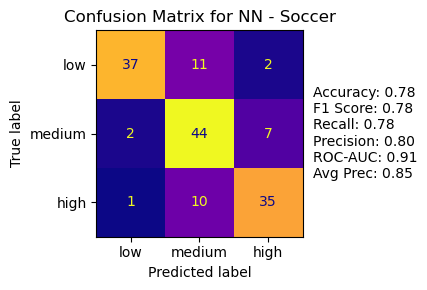

Accuracy: 0.7785
F1 Score: 0.7813
Recall Score: 0.7785


In [ ]:
final_model = SimpleNN(
    input_dim=X_train_tensor_soccer.shape[1],
    units=64,
    dropout=0.5,
    n_layers=3,
    num_classes=3
)
final_model.load_state_dict(torch.load("models/final_model_soccer.pth"))

final_model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for xb, yb in test_loader_soccer:
        preds = final_model(xb)
        predicted_classes = preds.argmax(dim=1)
        logits = final_model(xb)               # raw outputs (logits)
        probs = torch.softmax(logits, dim=1)  # convert logits to probabilities
        all_probs.append(probs.cpu().numpy())
        all_preds.extend(predicted_classes.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

all_probs = np.vstack(all_probs)

idx_to_label = {0: "low", 1: "medium", 2: "high"}
tier_order = ["low", "medium", "high"]

# Map numeric labels back to strings
all_labels_str = [idx_to_label[idx] for idx in all_labels]
all_preds_str = [idx_to_label[idx] for idx in all_preds]
all_labels_bin = label_binarize(all_labels, classes=[0,1,2])
print(classification_report(all_labels_str, all_preds_str, target_names=tier_order))

accuracy = accuracy_score(all_labels_str, all_preds_str)
f1 = f1_score(all_labels_str, all_preds_str, average="weighted")
recall = recall_score(all_labels_str, all_preds_str, average="weighted")
prec = precision_score(all_labels_str, all_preds_str, average="weighted")
roc_auc = roc_auc_score(all_labels_bin, all_probs)
avg_prec = average_precision_score(all_labels_bin, all_probs)

cm_soccer = confusion_matrix(all_labels_str, all_preds_str, labels=tier_order)
fig, ax = plt.subplots(figsize=(5,3))
disp_soccer = ConfusionMatrixDisplay(confusion_matrix=cm_soccer, display_labels=tier_order)
disp_soccer.plot(ax=ax, cmap="plasma", colorbar=False)
disp_soccer.ax_.set_title('Confusion Matrix for NN - Soccer')

textstr = f'Accuracy: {accuracy:.2f}\nF1 Score: {f1:.2f}\nRecall: {recall:.2f}\nPrecision: {prec:.2f}\nROC-AUC: {roc_auc:.2f}\nAvg Prec: {avg_prec:.2f}'
ax.text(1.05, 0.5, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='center')
plt.tight_layout()
plt.savefig("images/5/cm_nn_soccer.png", dpi=300, bbox_inches='tight')#, facecolor="#E7E7E7")
plt.show()

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Recall Score: {recall:.4f}')

In [42]:
labels_df = pd.DataFrame({
    "true_label": all_labels_str,
    "predicted_label": all_preds_str
}, index=y_test_soccer.index)

# Merge labels with original soccer dataframe on index
merged = df_soccer.loc[y_test_soccer.index].copy()
merged = merged.join(labels_df)

# Identify underpriced and overpriced cases based on true vs predicted
underpriced = merged[(merged["true_label"] == "low") & (merged["predicted_label"] == "high")]
overpriced = merged[(merged["true_label"] == "high") & (merged["predicted_label"] == "low")]

print("Underpriced Candidates:")
display(underpriced[["title", "price.value", "seller.feedbackScore", "days_listed", "title_length", "true_label", "predicted_label"]])

print("Overpriced Candidates:")
display(overpriced[["title", "price.value", "seller.feedbackScore", "days_listed", "title_length", "true_label", "predicted_label"]])

Underpriced Candidates:


,title,price.value,seller.feedbackScore,days_listed,title_length,true_label,predicted_label
896,Vitesse 2014-15 Home jersey mens size M macron,29.00,1477,186,46,low,high
458,CHELSEA 2006/2008 HOME FOOTBALL SHIRT KIT SOCC...,29.99,2017,76,80,low,high


Overpriced Candidates:


,title,price.value,seller.feedbackScore,days_listed,title_length,true_label,predicted_label
518,Adidas Spain #6 A. Iniesta 2010 Away Soccer Je...,98.0,2582,8,80,high,low


#### Regression

In [43]:
y_soccer = df_soccer['price.value']
                         
X_train_soccer, X_test_soccer, y_train_soccer, y_test_soccer = train_test_split(X_encoded_soccer, y_soccer,
                                                                 test_size=0.20, random_state=1216) 

X_train_soccer, X_val_soccer, y_train_soccer, y_val_soccer = train_test_split(X_train_soccer, y_train_soccer,
                                                                test_size=0.20, random_state=1216)

y_train_tensor_soccer = torch.tensor(y_train_soccer.values, dtype=torch.float32).view(-1, 1)
y_val_tensor_soccer = torch.tensor(y_val_soccer.values, dtype=torch.float32).view(-1, 1)
y_test_tensor_soccer = torch.tensor(y_test_soccer.values, dtype=torch.float32).view(-1, 1)

train_dataset_soccer = TensorDataset(X_train_tensor_soccer, y_train_tensor_soccer)
val_dataset_soccer = TensorDataset(X_val_tensor_soccer, y_val_tensor_soccer)
test_dataset_soccer = TensorDataset(X_test_tensor_soccer, y_test_tensor_soccer)

train_loader_soccer = DataLoader(train_dataset_soccer, batch_size=32, shuffle=True)
val_loader_soccer = DataLoader(val_dataset_soccer, batch_size=32, shuffle=False)
test_loader_soccer = DataLoader(test_dataset_soccer, batch_size=32, shuffle=False)

In [44]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, units, dropout, n_layers):
        super(SimpleNN, self).__init__()
        layers = []
        # First layer
        layers.append(nn.Linear(input_dim, units))
        layers.append(nn.BatchNorm1d(units)) 
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        # Hidden layers
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(units, units))
            layers.append(nn.BatchNorm1d(units)) 
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(units, 1))  
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)
    
def train_and_evaluate(units, dropout, lr, n_layers, epochs=10):
    model = SimpleNN(input_dim=X_train_tensor_soccer.shape[1], units=units, dropout=dropout, n_layers=n_layers)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader_soccer:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        # Validation per epoch
        model.eval()
        val_loss = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader_soccer:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
                val_total += yb.size(0)
        val_loss /= val_total
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}")
    return val_loss

In [45]:
# from itertools import product
# param_grid = {
#     'units': [32, 64],
#     'dropout': [0.3, 0.4, 0.5],
#     'learning_rate': [0.0005, 0.001, 0.005, 0.01],
#     'n_layers': [1, 2, 3]
# }
# results = []
# for units, dropout, lr, n_layers in product(param_grid['units'], param_grid['dropout'], param_grid['learning_rate'],
#                                  param_grid['n_layers']):
#     val_loss = train_and_evaluate(units, dropout, lr, n_layers, 15)
#     print(f"units={units}, dropout={dropout}, lr={lr}, n_layers={n_layers}, val_loss={val_loss:.4f}")
#     results.append({'units': units, 'dropout': dropout, 'lr': lr, 'n_layers': n_layers, 'val_loss': val_loss})

In [46]:
# best = min(results, key=lambda x: x['val_loss'])
# print(f"Best hyperparams: {best}")
# best_params = {k: best[k] for k in ['units', 'dropout', 'lr', 'n_layers']}

Best hyperparams: {'units': 32, 'dropout': 0.3, 'lr': 0.01, 'n_layers': 3, 'val_loss': 393.70084746545103}


In [ ]:
# X_combined_soccer = torch.cat([X_train_tensor_soccer, X_val_tensor_soccer], dim=0)
# y_combined_soccer = torch.cat([y_train_tensor_soccer, y_val_tensor_soccer], dim=0)
# combined_dataset_soccer = TensorDataset(X_combined_soccer, y_combined_soccer)
# combined_loader_soccer = DataLoader(combined_dataset_soccer, batch_size=32, shuffle=True)

# # Create new model using best hyperparameters
# final_model = SimpleNN(
#     input_dim=X_train_tensor_soccer.shape[1],
#     units=32,
#     dropout=0.3,
#     n_layers=3,
# )
# optimizer = torch.optim.AdamW(final_model.parameters(), lr=0.01)
# criterion = torch.nn.MSELoss()

# train_losses = []

# for epoch in range(50):
#     final_model.train()
#     running_loss = 0
#     total = 0
#     for xb, yb in combined_loader_soccer:
#         optimizer.zero_grad()
#         preds = final_model(xb)  # shape: [batch_size, num_classes]
#         loss = criterion(preds, yb)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * xb.size(0)
#         total += yb.size(0)
#     epoch_loss = running_loss / total
#     train_losses.append(epoch_loss)
#     print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# torch.save(final_model.state_dict(), "models/final_model_soccer_reg.pth")


In [ ]:
final_model = SimpleNN(
    input_dim=X_train_tensor_soccer.shape[1],
    units=32,
    dropout=0.3,
    n_layers=3,
)
final_model.load_state_dict(torch.load("models/final_model_soccer_reg.pth"))
criterion = torch.nn.MSELoss()

final_model.eval()
with torch.no_grad():
    preds = final_model(X_test_tensor_soccer)
    mse = criterion(preds, y_test_tensor_soccer).item()
    rmse = mse ** 0.5
    print(f"Test MSE: {mse:.2f}, RMSE: {rmse:.2f}")

Test MSE: 561.44, RMSE: 23.69


In [ ]:
final_model = SimpleNN(
    input_dim=X_train_tensor_soccer.shape[1],
    units=32,
    dropout=0.3,
    n_layers=3,
)
final_model.load_state_dict(torch.load("models/final_model_soccer_reg.pth"))

final_model.eval()
with torch.no_grad():
    preds = final_model(X_test_tensor_soccer).cpu().numpy().flatten()
    targets = y_test_soccer.values.flatten()

errors = preds - targets   # positive = underpriced, negative = overpriced
abs_errors = np.abs(errors)

top_n = 10
biggest_misses_pos = np.argsort(abs_errors)[-top_n:][::-1]  # positions in test set
orig_idx = X_test_soccer.index[biggest_misses_pos]           # original df_soccer index


misses_df = df_soccer.loc[orig_idx, ["title", "club", "country", "condition"]].copy()
misses_df["Predicted"] = preds[biggest_misses_pos]
misses_df["Actual"] = targets[biggest_misses_pos]
misses_df["Error"] = errors[biggest_misses_pos]
misses_df["Price_Tag"] = np.where(
    misses_df["Error"] > 0,
    "Potentially Underpriced",
    "Potentially Overpriced"
)

print(f"Top {top_n} biggest misses:")
print(misses_df.sort_values(by="Error", key=np.abs, ascending=False))

Top 10 biggest misses:
                                                 title          club  \
126   Puma Chivas Retro Street 2025 Chivas Jersey 2025           NaN   
518  Adidas Spain #6 A. Iniesta 2010 Away Soccer Je...           NaN   
734  Barcelona FC Spain - Nike 2022/2023 Home Jerse...     Barcelona   
321        La Liga Jersey Sleeve Badge Patch 2024-2025           NaN   
705  Adidas Argentina National Football Team Soccer...           NaN   
388  Peru Men's 2018 Umbro Red/White Replica Soccer...           NaN   
458  CHELSEA 2006/2008 HOME FOOTBALL SHIRT KIT SOCC...       Chelsea   
938  Club America 24/25 Third Dri Fit Adv Nike Socc...  Club America   
607  Official Japan 2022 Home Jersey Shirt - Mitoma...           NaN   
856  Costa Rica Lotto 2014 World Cup Soccer Jersey ...           NaN   

       country      condition  Predicted  Actual       Error  \
126        NaN  New with tags  43.517834  279.99 -236.472166   
518      Spain           Used  39.213799   98.00  -58.78

In [50]:
misses_df.sort_values(by="Error", key=np.abs, ascending=False)

,title,club,country,condition,Predicted,Actual,Error,Price_Tag
126,Puma Chivas Retro Street 2025 Chivas Jersey 2025,NaN,NaN,New with tags,43.517834,279.99,-236.472166,Potentially Overpriced
518,Adidas Spain #6 A. Iniesta 2010 Away Soccer Je...,NaN,Spain,Used,39.213799,98.00,-58.786201,Potentially Overpriced
734,Barcelona FC Spain - Nike 2022/2023 Home Jerse...,Barcelona,Spain,New,72.505219,120.00,-47.494781,Potentially Overpriced
321,La Liga Jersey Sleeve Badge Patch 2024-2025,NaN,NaN,New,47.645702,8.00,39.645702,Potentially Underpriced
705,Adidas Argentina National Football Team Soccer...,NaN,Argentina,New,62.366676,100.00,-37.633324,Potentially Overpriced
388,Peru Men's 2018 Umbro Red/White Replica Soccer...,NaN,NaN,New,48.557644,85.00,-36.442356,Potentially Overpriced
458,CHELSEA 2006/2008 HOME FOOTBALL SHIRT KIT SOCC...,Chelsea,NaN,Used,61.732376,29.99,31.742376,Potentially Underpriced
938,Club America 24/25 Third Dri Fit Adv Nike Socc...,Club America,NaN,New,54.075001,84.95,-30.874999,Potentially Overpriced
607,Official Japan 2022 Home Jersey Shirt - Mitoma...,NaN,NaN,Used,74.029221,99.00,-24.970779,Potentially Overpriced
856,Costa Rica Lotto 2014 World Cup Soccer Jersey ...,NaN,NaN,Used,54.488083,30.00,24.488083,Potentially Underpriced


#### Log Price regression

In [51]:
y_soccer = df_soccer['price.value']
                         
X_train_soccer, X_test_soccer, y_train_soccer, y_test_soccer = train_test_split(X_encoded_soccer, y_soccer,
                                                                 test_size=0.20, random_state=1216) 

X_train_soccer, X_val_soccer, y_train_soccer, y_val_soccer = train_test_split(X_train_soccer, y_train_soccer,
                                                                test_size=0.20, random_state=1216)

y_train_log = np.log(y_train_soccer.values)
y_val_log = np.log(y_val_soccer.values)
y_test_log = np.log(y_test_soccer.values)

y_train_tensor_soccer_log = torch.tensor(y_train_log, dtype=torch.float32).view(-1, 1)
y_val_tensor_soccer_log = torch.tensor(y_val_log, dtype=torch.float32).view(-1, 1)
y_test_tensor_soccer_log = torch.tensor(y_test_log, dtype=torch.float32).view(-1, 1)

train_dataset_soccer_log = TensorDataset(X_train_tensor_soccer, y_train_tensor_soccer_log)
val_dataset_soccer_log = TensorDataset(X_val_tensor_soccer, y_val_tensor_soccer_log)
test_dataset_soccer_log = TensorDataset(X_test_tensor_soccer, y_test_tensor_soccer_log)

train_loader_soccer_log = DataLoader(train_dataset_soccer_log, batch_size=32, shuffle=True)
val_loader_soccer_log = DataLoader(val_dataset_soccer_log, batch_size=32, shuffle=False)
test_loader_soccer_log = DataLoader(test_dataset_soccer_log, batch_size=32, shuffle=False)

In [52]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_and_evaluate(units, dropout, lr, n_layers, epochs=30, patience=5):
    model = SimpleNN(input_dim=X_train_tensor_soccer.shape[1], units=units, dropout=dropout, n_layers=n_layers)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
    
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader_soccer_log:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0
        val_total = 0
        with torch.no_grad():
            for xb, yb in val_loader_soccer_log:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_loss += loss.item() * xb.size(0)
                val_total += yb.size(0)
        val_loss /= val_total
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping!")
                break
    return best_val_loss

In [53]:
from itertools import product
param_grid = {
    'units': [32, 64],
    'dropout': [0.3, 0.4, 0.5],
    'learning_rate': [0.0005, 0.001, 0.005, 0.01],
    'n_layers': [1, 2, 3]
}
results = []
for units, dropout, lr, n_layers in product(param_grid['units'], param_grid['dropout'], param_grid['learning_rate'],
                                 param_grid['n_layers']):
    val_loss = train_and_evaluate(units, dropout, lr, n_layers, 10)
    print(f"units={units}, dropout={dropout}, lr={lr}, n_layers={n_layers}, val_loss={val_loss:.4f}")
    results.append({'units': units, 'dropout': dropout, 'lr': lr, 'n_layers': n_layers, 'val_loss': val_loss})

Epoch 1, Val Loss: 15.9464
Epoch 2, Val Loss: 15.3721
Epoch 3, Val Loss: 14.5996
Epoch 4, Val Loss: 13.7892
Epoch 5, Val Loss: 12.9066
Epoch 6, Val Loss: 12.1414
Epoch 7, Val Loss: 11.3632
Epoch 8, Val Loss: 10.5610
Epoch 9, Val Loss: 9.8603
Epoch 10, Val Loss: 9.1857
units=32, dropout=0.3, lr=0.0005, n_layers=1, val_loss=9.1857
Epoch 1, Val Loss: 14.7862
Epoch 2, Val Loss: 14.4776
Epoch 3, Val Loss: 13.8569
Epoch 4, Val Loss: 13.2439
Epoch 5, Val Loss: 12.6670
Epoch 6, Val Loss: 12.0756
Epoch 7, Val Loss: 11.3982
Epoch 8, Val Loss: 10.7673
Epoch 9, Val Loss: 10.0875
Epoch 10, Val Loss: 9.5817
units=32, dropout=0.3, lr=0.0005, n_layers=2, val_loss=9.5817
Epoch 1, Val Loss: 14.6377
Epoch 2, Val Loss: 13.6439
Epoch 3, Val Loss: 12.5928
Epoch 4, Val Loss: 12.1022
Epoch 5, Val Loss: 11.3627
Epoch 6, Val Loss: 10.9768
Epoch 7, Val Loss: 10.3362
Epoch 8, Val Loss: 9.6682
Epoch 9, Val Loss: 9.1612
Epoch 10, Val Loss: 8.5691
units=32, dropout=0.3, lr=0.0005, n_layers=3, val_loss=8.5691
Epoch 1

In [54]:
best = min(results, key=lambda x: x['val_loss'])
print(f"Best hyperparams: {best}")
best_params = {k: best[k] for k in ['units', 'dropout', 'lr', 'n_layers']}

Best hyperparams: {'units': 64, 'dropout': 0.3, 'lr': 0.01, 'n_layers': 2, 'val_loss': 0.25541515786106844}


In [55]:
X_combined_soccer = torch.cat([X_train_tensor_soccer, X_val_tensor_soccer], dim=0)
y_combined_soccer_log = torch.cat([y_train_tensor_soccer_log, y_val_tensor_soccer_log], dim=0)
combined_dataset_soccer_log = TensorDataset(X_combined_soccer, y_combined_soccer_log)
combined_loader_soccer_log = DataLoader(combined_dataset_soccer_log, batch_size=32, shuffle=True)

# Create new model using best hyperparameters
final_model = SimpleNN(
    input_dim=X_train_tensor_soccer.shape[1],
    units=best_params['units'],
    dropout=best_params['dropout'],
    n_layers=best_params['n_layers'],
)
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_params['lr'])
criterion = torch.nn.MSELoss()

train_losses = []

for epoch in range(50):
    final_model.train()
    running_loss = 0
    total = 0
    for xb, yb in combined_loader_soccer_log:
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
        total += yb.size(0)
    epoch_loss = running_loss / total
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

Epoch 1, Loss: 5.8759
Epoch 2, Loss: 1.0882
Epoch 3, Loss: 0.6879
Epoch 4, Loss: 0.5320
Epoch 5, Loss: 0.5450
Epoch 6, Loss: 0.5390
Epoch 7, Loss: 0.5047
Epoch 8, Loss: 0.4200
Epoch 9, Loss: 0.4235
Epoch 10, Loss: 0.4136
Epoch 11, Loss: 0.4130
Epoch 12, Loss: 0.3547
Epoch 13, Loss: 0.3477
Epoch 14, Loss: 0.3088
Epoch 15, Loss: 0.3336
Epoch 16, Loss: 0.3474
Epoch 17, Loss: 0.3163
Epoch 18, Loss: 0.3302
Epoch 19, Loss: 0.2853
Epoch 20, Loss: 0.2849
Epoch 21, Loss: 0.2767
Epoch 22, Loss: 0.2807
Epoch 23, Loss: 0.2696
Epoch 24, Loss: 0.2543
Epoch 25, Loss: 0.2373
Epoch 26, Loss: 0.2620
Epoch 27, Loss: 0.2331
Epoch 28, Loss: 0.2016
Epoch 29, Loss: 0.2651
Epoch 30, Loss: 0.2307
Epoch 31, Loss: 0.2295
Epoch 32, Loss: 0.2324
Epoch 33, Loss: 0.2125
Epoch 34, Loss: 0.2219
Epoch 35, Loss: 0.2033
Epoch 36, Loss: 0.1944
Epoch 37, Loss: 0.2102
Epoch 38, Loss: 0.1663
Epoch 39, Loss: 0.1898
Epoch 40, Loss: 0.1938
Epoch 41, Loss: 0.1790
Epoch 42, Loss: 0.1857
Epoch 43, Loss: 0.1982
Epoch 44, Loss: 0.19

In [56]:
# Compute residuals on val set to estimate sigma² for back-transformation
final_model.eval()
with torch.no_grad():
    preds_val_log = final_model(X_val_tensor_soccer)
    residuals_log = preds_val_log - y_val_tensor_soccer_log
    sigma2 = torch.var(residuals_log)  # used in log-normal correction

# Evaluate on test set with log-normal correction
all_preds = []
all_targets = []
all_preds_log = []
all_targets_log = []
with torch.no_grad():
    for xb, yb in test_loader_soccer_log:  
        preds_log = final_model(xb)
        preds = torch.exp(preds_log + sigma2 / 2)  # apply correction
        targets = torch.exp(yb)
        all_preds_log.append(preds_log)
        all_targets_log.append(yb)
        all_preds.append(preds)
        all_targets.append(targets)

all_preds_log = torch.cat(all_preds_log).cpu().numpy()
all_targets_log = torch.cat(all_targets_log).cpu().numpy()
all_preds = torch.cat(all_preds).cpu().numpy()
all_targets = torch.cat(all_targets).cpu().numpy()

rmse_log = np.sqrt(np.mean((all_preds_log - all_targets_log)**2))
print(f"Test RMSE (log scale): {rmse_log:.4f}")
rmse = np.sqrt(np.mean((all_preds - all_targets)**2))
print(f"Test RMSE (original scale): {rmse:.4f}")

Test RMSE (log scale): 0.3409
Test RMSE (original scale): 25.1927


In [57]:
print("Raw predictions (log scale):", preds_log[:5])
print("Exp predictions:", preds[:5])
print("Raw targets (log scale):", yb[:5])
print("Exp targets:", targets[:5])

Raw predictions (log scale): tensor([[3.4371],
        [3.6048],
        [3.2966],
        [4.0944],
        [3.4133]])
Exp predictions: tensor([[31.9947],
        [37.8358],
        [27.8016],
        [61.7379],
        [31.2438]])
Raw targets (log scale): tensor([[3.6889],
        [3.3673],
        [3.3666],
        [4.0942],
        [3.4337]])
Exp targets: tensor([[40.0000],
        [29.0000],
        [28.9800],
        [59.9900],
        [30.9900]])


#### MLR

In [58]:
X_combined_soccer = pd.concat([X_train_soccer, X_val_soccer], axis=0)
y_combined_soccer = pd.concat([y_train_soccer, y_val_soccer], axis=0)

# Add constant (intercept)
X = sm.add_constant(X_combined_soccer.astype(float))  
model = sm.OLS(y_combined_soccer, X).fit()

# Get summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            price.value   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     11.33
Date:                Sun, 10 Aug 2025   Prob (F-statistic):           2.40e-68
Time:                        14:16:33   Log-Likelihood:                -2563.1
No. Observations:                 595   AIC:                             5268.
Df Residuals:                     524   BIC:                             5580.
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [59]:
# Add constant (intercept)
y_combined_soccer_log = np.log(y_combined_soccer)
X = sm.add_constant(X_combined_soccer.astype(float))  # or: sm.add_constant(df[['feature1', 'feature2', ...]])
model_log = sm.OLS(y_combined_soccer_log, X).fit()

# Get summary
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:            price.value   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.553
Method:                 Least Squares   F-statistic:                     11.50
Date:                Sun, 10 Aug 2025   Prob (F-statistic):           2.78e-69
Time:                        14:16:33   Log-Likelihood:                -88.574
No. Observations:                 595   AIC:                             319.1
Df Residuals:                     524   BIC:                             630.7
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [60]:
X_test_soccer_const = sm.add_constant(X_test_soccer, has_constant='add')

y_test_pred_orig = model.predict(X_test_soccer_const)
test_rmse_orig = np.sqrt(mean_squared_error(y_test_soccer, y_test_pred_orig))
print(f"Original Price - Test RMSE: {test_rmse_orig:.4f}")

y_test_pred_log = model_log.predict(X_test_soccer_const)
y_test_pred_log = np.array(y_test_pred_log, dtype=float)
y_test_pred_log_exp = np.exp(y_test_pred_log)  # back-transform

test_rmse_log = np.sqrt(mean_squared_error(np.log(y_test_soccer), y_test_pred_log))
print(f"Log Price - Test RMSE: {test_rmse_log:.4f}")
test_rmse_log_exp = np.sqrt(mean_squared_error(y_test_soccer, y_test_pred_log_exp))
print(f"Log Price Converted - Test RMSE: {test_rmse_log_exp:.4f}")

Original Price - Test RMSE: 29.8098
Log Price - Test RMSE: 0.3825
Log Price Converted - Test RMSE: 28.5054


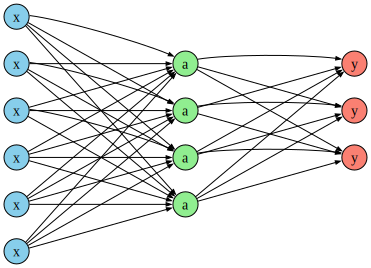

In [62]:
from graphviz import Source
dot = """digraph G {
  rankdir=LR;
  splines=line;
  ranksep=2;    // default ~1, bigger is wider
  nodesep=0.3;  // default ~0.6, smaller is shorter vertically
  node [shape=circle, style=filled, width=0.35, fixedsize=true];
  edge [arrowsize=0.5]

  // Input layer (6 nodes)
  x1 [label="x", fillcolor=skyblue];
  x2 [label="x", fillcolor=skyblue];
  x3 [label="x", fillcolor=skyblue];
  x4 [label="x", fillcolor=skyblue];
  x5 [label="x", fillcolor=skyblue];
  x6 [label="x", fillcolor=skyblue];

  // Hidden layer (4 nodes)
  a1 [label="a", fillcolor=lightgreen];
  a2 [label="a", fillcolor=lightgreen];
  a3 [label="a", fillcolor=lightgreen];
  a4 [label="a", fillcolor=lightgreen];

  // Output layer (3 nodes)
  y1 [label="y", fillcolor=salmon];
  y2 [label="y", fillcolor=salmon];
  y3 [label="y", fillcolor=salmon];

  { rank=same; x1; x2; x3; x4; x5; x6; }
  { rank=same; a1; a2; a3; a4; }
  { rank=same; y1; y2; y3; }

  x1 -> x2 [style=invis];
  x2 -> x3 [style=invis];
  x3 -> x4 [style=invis];
  x4 -> x5 [style=invis];
  x5 -> x6 [style=invis];

  a1 -> a2 [style=invis];
  a2 -> a3 [style=invis];
  a3 -> a4 [style=invis];

  y1 -> y2 [style=invis];
  y2 -> y3 [style=invis];

  x1 -> a1 [style=invis];
  a1 -> y1 [style=invis];
  x2 -> a2 [style=invis];
  a2 -> y2 [style=invis];
  x3 -> a3 [style=invis];
  a3 -> y3 [style=invis];

  x1 -> {a1 a2 a3 a4};
  x2 -> {a1 a2 a3 a4};
  x3 -> {a1 a2 a3 a4};
  x4 -> {a1 a2 a3 a4};
  x5 -> {a1 a2 a3 a4};
  x6 -> {a1 a2 a3 a4};

  a1 -> {y1 y2 y3};
  a2 -> {y1 y2 y3};
  a3 -> {y1 y2 y3};
  a4 -> {y1 y2 y3};
}
"""
Source(dot)


In [63]:
import graphviz
graph = graphviz.Source(dot)
graph.render('images/5/nn_graph', format='png', cleanup=True)

'images/5/nn_graph.png'